In [1]:
import numpy as np
from numpy import radians

### Criação da aeronave

In [2]:
from aircraft import Aircraft
minhaAeronave = Aircraft(mass=45e3, Ixx=0.554e6, Iyy=2.53e6,
                         Izz =3.01e6, Izx=0.106e6, Cbarw =3.666,
                         bw=28.42, Sw=95.0)

minhaAeronave.coef0 = [0.0252, 0.0, 0.382, 0.0, 0.0622, 0.0]
minhaAeronave.coefALPHA = [0.2010, 0.0, 6.29, 0.0, -3.63, 0.0]
minhaAeronave.coefBETA = [0.0, 0.785, 0.0, -0.121, 0.0, 0.174]
minhaAeronave.coefP = [0.0, -0.0794, 0.0, -0.522, 0.0, -0.0587]
minhaAeronave.coefQ = [0.281, 0.0, 14.6, 0.0, -45.5, 0.0]
minhaAeronave.coefR = [0.0, 0.572, 0.0, 0.254, 0.0, -0.277]

minhaAeronave.CLmax = 2.4
minhaAeronave.qmax = 23052.05
minhaAeronave.Vinf = 200

minhaAeronave.set_control_surface('Profundor', [0.0126, 0.0, 0.3891, 0.0, -1.5980, 0.0],(radians(-30), radians(30)))
minhaAeronave.set_control_surface('Aileron', [0.0, 0.0094, 0.0, -0.1784, 0.0, 0.0080],(radians(-20), radians(30)))
minhaAeronave.set_control_surface('Leme', [0.0, -0.3030, 0.0, -0.0464, 0.0, -0.1594],(radians(-40), radians(40)))

### Criação da atmosfera

In [3]:
from atmosphere import atmosISA
minhaAtmosfera = atmosISA(deltaT = 298.15)

### Criação da gravidade

In [4]:
from gravity import NewtonGravity
minhaGravidade = NewtonGravity()

### Criação do modelo propulsivo

In [5]:
import numpy as np

from propulsion import JetModel
MotorEsquerdo = JetModel('Motor esquerdo', Fmaxi = 35e3, nrho = 0.775, rhoi = 0.41271,
                         Vi = 200.0, nv = 0)
MotorEsquerdo.position = np.array([0, -5, 1.42])
MotorEsquerdo.attitude = np.array([0., radians(0.), 0.])

MotorDireito = JetModel('Motor direito', Fmaxi = 35e3, nrho = 0.775, rhoi = 0.41271,
                         Vi = 200.0, nv = 0)
MotorDireito.position = np.array([0, 5.0, 1.42])
MotorDireito.attitude = np.array([0., radians(0.), 0.])

minhaPropulsao = [MotorEsquerdo, MotorDireito]

### Criação do sistema

In [6]:
from system import system
meuSistema = system(atmosphere = minhaAtmosfera,
                    propulsion = minhaPropulsao,
                    aircraft = minhaAeronave,
                    gravity = minhaGravidade)

### Trimagem

In [7]:
varFixas = {'zo':-10000.0, 'u': 224.6, 'phi':0.0, 'Motor esquerdo phip':0.0,
            'Motor direito phip': 0.0,  'Motor esquerdo thetap':radians(3.0),
            'Motor direito thetap': radians(3.0), 'v': 0.0,}

varDesejadas = {'zod':0.0, 'ud':0.0, 'vd':0.0, 'wd':0.0, 'phid':0.0,
                'psid':radians(0.0), 'thetad':0.0, 'pd':0.0 , 'qd':0.0, 'rd':0.0}

varLivres = {'w':1.0, 'theta':1.0, 'p': 1.0, 'q':1.0, 'r':1.0,
             'Motor direito thrust': 0.5, 'Motor esquerdo thrust': 0.5, 'Aileron': radians(1.0),
             'Profundor':0.0, 'Leme': radians(0.5)}

Xe, Ue = meuSistema.trimmer(condition = 'general', fixed = varFixas, desired = varDesejadas, free = varLivres)

### Cálculo do balanço

In [8]:
Xe, Ue = meuSistema.trimmer(condition='cruize', zo = -10000., u = 224.6)

In [9]:
TS = 150

### Propagação de estados não-perturbados

In [10]:
solution1, controls1 = meuSistema.propagate(Xe, Ue, T0 = 0.0, TF = TS, dt = 0.01)
tempo1  = meuSistema.time

### Perturbação nos estados

In [11]:
import copy
meuSistema2 = copy.deepcopy(system(atmosphere = minhaAtmosfera,
                                   propulsion = minhaPropulsao,
                                   aircraft = minhaAeronave,
                                   gravity = minhaGravidade))

solution2, controls2 = meuSistema2.propagate(Xe, Ue,T0 = 0.0, TF = TS,
                                             state = {'beta':np.radians(2.),
                                                      'alpha':np.radians(5.)})
tempo2  = meuSistema2.time

### Perturbação nos controles

In [12]:
from pyaatcontrol import doublet, step

st0 = doublet('Profundor', amplitude = np.radians(2.), t_init = 10, T = 2)
st1 = doublet('Aileron', amplitude = np.radians(0.5), t_init = 30, T = 15)
st2 = doublet('Leme', amplitude = np.radians(0.5), t_init = 70, T = 15)
st3 = step('Motor esquerdo thrust', amplitude = 0.1, t_init = 100)
st4 = step('Motor direito thrust', amplitude = 0.1, t_init = 100.1)

openLoopPert = [st0, st1, st2, st3, st4]

In [13]:
meuSistema3 = copy.deepcopy(system(atmosphere = minhaAtmosfera,
                                   propulsion = minhaPropulsao, 
                                   aircraft = minhaAeronave,
                                   gravity = minhaGravidade))

In [14]:
solution3, controls3 = meuSistema3.propagate(Xe, Ue, TF = TS,
                                             control = openLoopPert,
                                             state = {'beta': np.radians(-2.),
                                                      'alpha':np.radians(-5.)})
tempo3  = meuSistema3.time

### Plot figures 

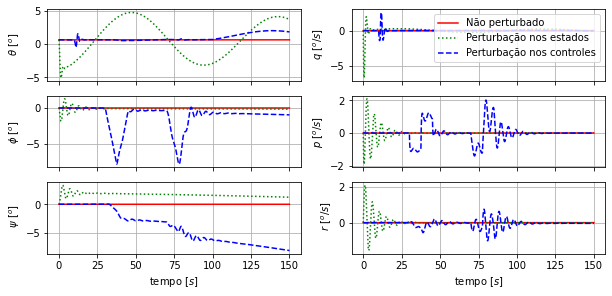

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(10,4.5))
ax[1,0].plot(tempo1, np.around(np.degrees(solution1[:,6]), decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[1,0].plot(tempo2, np.around(np.degrees(solution2[:,6]), decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[1,0].plot(tempo3, np.around(np.degrees(solution3[:,6]), decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[1,0].set_ylabel(r'$\phi~ [^o]$')
ax[1,0].grid()

ax[0,0].plot(tempo1, np.around(np.degrees(solution1[:,7]), decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[0,0].plot(tempo2, np.around(np.degrees(solution2[:,7]), decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[0,0].plot(tempo3, np.around(np.degrees(solution3[:,7]), decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[0,0].set_ylabel(r' $\theta~ [^o]$')
ax[0,0].grid()

ax[2,0].plot(tempo1, np.around(np.degrees(solution1[:,8]), decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[2,0].plot(tempo2, np.around(np.degrees(solution2[:,8]), decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[2,0].plot(tempo3, np.around(np.degrees(solution3[:,8]), decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[2,0].set_ylabel(r' $\psi~ [^o]$')
ax[2,0].set_xlabel(r'tempo $[s]$')
ax[2,0].grid()

ax[1, 1].plot(tempo1, np.around(np.degrees(solution1[:,9]), decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[1, 1].plot(tempo2, np.around(np.degrees(solution2[:,9]), decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[1, 1].plot(tempo3, np.around(np.degrees(solution3[:,9]), decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[1, 1].set_ylabel(r'$p~ [^o/s]$')
ax[1, 1].grid()

ax[0, 1].plot(tempo1, np.around(np.degrees(solution1[:,10]), decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[0, 1].plot(tempo2, np.around(np.degrees(solution2[:,10]), decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[0, 1].plot(tempo3, np.around(np.degrees(solution3[:,10]), decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[0, 1].set_ylabel(r' $q~ [^o/s]$')
ax[0, 1].legend(loc = 'upper right')

ax[0, 1].grid()

ax[2, 1].plot(tempo1, np.around(np.degrees(solution1[:,11]), decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[2, 1].plot(tempo2, np.around(np.degrees(solution2[:,11]), decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[2, 1].plot(tempo3, np.around(np.degrees(solution3[:,11]), decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[2, 1].set_ylabel(r' $r~ [^o/s]$')
ax[2, 1].set_xlabel(r'tempo $[s]$')
ax[2, 1].grid()
plt.savefig('PT0_angular.png', dpi = 400, bbox_inches='tight')

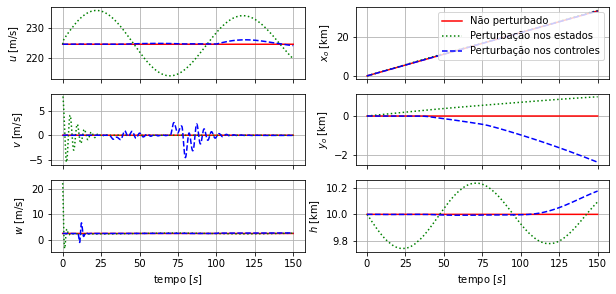

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(10,4.5))
ax[0,0].plot(tempo1, np.around((solution1[:,3]), decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[0,0].plot(tempo2, np.around((solution2[:,3]), decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[0,0].plot(tempo3, np.around((solution3[:,3]), decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[0,0].set_ylabel(r'$u$ [m/s]')
ax[0,0].grid()

ax[1,0].plot(tempo1, np.around((solution1[:,4]), decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[1,0].plot(tempo2, np.around((solution2[:,4]), decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[1,0].plot(tempo3, np.around((solution3[:,4]), decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[1,0].set_ylabel(r'$v$ [m/s]')
ax[1,0].grid()

ax[2,0].plot(tempo1, np.around((solution1[:,5]), decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[2,0].plot(tempo2, np.around((solution2[:,5]), decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[2,0].plot(tempo3, np.around((solution3[:,5]), decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[2,0].set_ylabel(r'$w$ [m/s]')
ax[2,0].set_xlabel(r'tempo $[s]$')
ax[2,0].grid()

ax[0, 1].plot(tempo1, np.around((solution1[:,0]/1000), decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[0, 1].plot(tempo2, np.around((solution2[:,0]/1000), decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[0, 1].plot(tempo3, np.around((solution3[:,0]/1000), decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[0, 1].set_ylabel(r'$x_o$ [km]')
ax[0, 1].legend(loc = 'upper right')
ax[0, 1].grid()

ax[1, 1].plot(tempo1, np.around((solution1[:,1]/1000), decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[1, 1].plot(tempo2, np.around((solution2[:,1]/1000), decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[1, 1].plot(tempo3, np.around((solution3[:,1]/1000), decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[1, 1].set_ylabel(r'$y_o$ [km]')
ax[1, 1].grid()

ax[2, 1].plot(tempo1, np.around((-solution1[:,2]/1000), decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[2, 1].plot(tempo2, np.around((-solution2[:,2]/1000), decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[2, 1].plot(tempo3, np.around((-solution3[:,2]/1000), decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[2, 1].set_ylabel(r'$h$ [km]')
ax[2, 1].set_xlabel(r'tempo $[s]$')
ax[2, 1].grid()
plt.savefig('PT0_linear.png', dpi = 400, bbox_inches='tight')

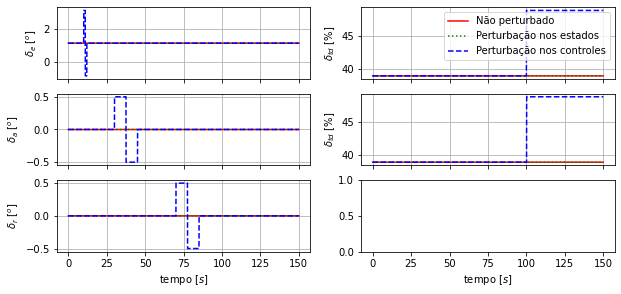

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(10,4.5))
ax[0,0].plot(tempo1, np.around(np.degrees(controls1[0,:]), decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[0,0].plot(tempo2, np.around(np.degrees(controls2[0,:]), decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[0,0].plot(tempo3, np.around(np.degrees(controls3[0,:]), decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[0,0].set_ylabel(r'$\delta_e$ $[^o]$')
ax[0,0].grid()

ax[1,0].plot(tempo1, np.around(np.degrees(controls1[1,:]), decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[1,0].plot(tempo2, np.around(np.degrees(controls2[1,:]), decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[1,0].plot(tempo3, np.around(np.degrees(controls3[1,:]), decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[1,0].set_ylabel(r'$\delta_a$ $[^o]$')
ax[1,0].grid()

ax[2,0].plot(tempo1, np.around(np.degrees(controls1[2,:]), decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[2,0].plot(tempo2, np.around(np.degrees(controls2[2,:]), decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[2,0].plot(tempo3, np.around(np.degrees(controls3[2,:]), decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[2,0].set_ylabel(r'$\delta_r$ $[^o]$')
ax[2,0].set_xlabel(r'tempo $[s]$')
ax[2,0].grid()

ax[0, 1].plot(tempo1, np.around((controls1[3,:])*100, decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[0, 1].plot(tempo2, np.around((controls2[3,:])*100, decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[0, 1].plot(tempo3, np.around((controls3[3,:])*100, decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[0, 1].set_ylabel(r'$\delta_{te}$  $[\%]$')
ax[0, 1].legend(loc = 'upper right')
ax[0, 1].set_ylabel(r'$\delta_{td}$ $[\%]$')
ax[0, 1].grid()

ax[1, 1].plot(tempo1, np.around((controls1[6,:])*100, decimals=4), label = r'Não perturbado', color = 'r', linestyle = '-')
ax[1, 1].plot(tempo2, np.around((controls2[6,:])*100, decimals=4), label = r'Perturbação nos estados', color = 'g', linestyle = ':')
ax[1, 1].plot(tempo3, np.around((controls3[6,:])*100, decimals=4), label = r'Perturbação nos controles', color = 'b', linestyle = '--')
ax[1, 1].set_ylabel(r'$\delta_{td}$ $[\%]$')
ax[1, 1].grid()
ax[2, 1].set_xlabel(r'tempo $[s]$')
plt.savefig('PT0_controles.png', dpi = 400, bbox_inches='tight')